# CartPole



## 1. Import and Install Modules

In [1]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [2]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

     |████████████████████████████████| 788kB 7.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 56.0.0
    Uninstalling setuptools-56.0.0:
      Successfully uninstalled setuptools-56.0.0


In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

##2. Define Video Utility 

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  print(mp4list)
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

##3. CartPole with Random Policy

Below we show how an agent chooses random actions to balance the cartpole. As we can see, the agent is not successful in balancing the cartpole.

In [6]:
env1=wrap_env(gym.make("CartPole-v0"))
observation = env1.reset()

In [7]:
while True:
  
    env1.render()
    
    #your agent goes here
    action = env1.action_space.sample() 
         
    observation, reward, done, info = env1.step(action) 
   
        
    if done: 
      break;
            
env1.close()
show_video()

['video/openaigym.video.0.59.video000000.mp4']


##4. Cartpole with SARSA

Here we will use SARSA algorithm to find a policy that keeps the cartpole balanced. 

The state space here consists of a 4 dimensional vector which includes the cart position, cart velocity, pole angle and pole velocity. These are continuous variables and in order to make calculations easier, we will discretize these variables into bins as shown below:

In [8]:
#discretize the spaces
poleThetaSpace = np.linspace(-0.20943951, 0.20943951, 10)
poleThetaVelSpace = np.linspace(-4, 4, 10)
cartPosSpace = np.linspace(-2.4, 2.4, 10)
cartVelSpace = np.linspace(-4, 4, 10)

In [9]:
#to plot the average of total rewards in each episode
def plotRunningAverage(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [10]:
#returns the action that maximizes the Q value at a particular state
def maxAction(Q, state):    
    values = np.array([Q[state,a] for a in range(2)])
    action = np.argmax(values)
    return action

#takes the state observation and returns the binned state observation
def getState(observation):
    cartX, cartXdot, cartTheta, cartThetadot = observation
    cartX = int(np.digitize(cartX, cartPosSpace))
    cartXdot = int(np.digitize(cartXdot, cartVelSpace))
    cartTheta = int(np.digitize(cartTheta, poleThetaSpace))
    cartThetadot = int(np.digitize(cartThetadot, poleThetaVelSpace))

    return (cartX, cartXdot, cartTheta, cartThetadot)

Now we will construct the state space which is the discretized version of the continuous state space:

In [11]:
env1 = gym.make('CartPole-v0')
# model hyperparameters
ALPHA = 0.1
GAMMA = 1.0    
EPS = 1.0

#construct state space
states = []
for i in range(len(cartPosSpace)+1):
    for j in range(len(cartVelSpace)+1):
        for k in range(len(poleThetaSpace)+1):
            for l in range(len(poleThetaVelSpace)+1):
                states.append((i,j,k,l))

Q = {}
for state in states:
    for action in range(2):
        Q[state, action] = 0

Here, we run the SARSA algorithm. We run 50,000 games in this simulation. The agent uses an Epsilon greedy strategy where in the initial games, it uses an exploration strategy and as it gets experience it starts to exploit on its understanding. 

The value function for the state,action pair is updated with the following formula

$Q(s,a)=Q(s,a)+\alpha [R+\gamma Q(s',a') - Q(s,a)]$

When the agent uses the exploitation strategy, it chooses the action that has the maximum Q value for a function. 


starting game 0
starting game 5000
starting game 10000
starting game 15000
starting game 20000
starting game 25000
starting game 30000
starting game 35000
starting game 40000
starting game 45000


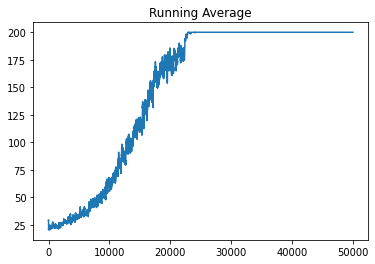

In [12]:
numGames = 50000
totalRewards = np.zeros(numGames)
for i in range(numGames):
    if i % 5000 == 0:
        print('starting game', i)
    # cart x position, cart velocity, pole theta, pole velocity
    observation = env1.reset()        
    state = getState(observation)
    rand = np.random.random()
    action = maxAction(Q, state) if rand < (1-EPS) else env1.action_space.sample()
    done = False
    epRewards = 0
    while not done:
        observation_, reward, done, info = env1.step(action)
        epRewards += reward
        state_ = getState(observation_)
        rand = np.random.random()
        action_ = maxAction(Q, state_) if rand < (1-EPS) else env1.action_space.sample()            
        Q[state,action] = Q[state,action] + ALPHA*(reward + GAMMA*Q[state_,action_] - Q[state,action])
        state, action = state_, action_            
    if EPS - 2 / numGames > 0:
        EPS -= 2 / numGames
    else:
        EPS = 0
    totalRewards[i] = epRewards
plotRunningAverage(totalRewards)

Now let us see the cartpole in action!

In [12]:
video_env2=wrap_env(gym.make("CartPole-v0"))
done=False
cnt=0
observation=video_env2.reset()       
state = getState(observation)
rand = np.random.random()
action = maxAction(Q, state) if rand < (1-EPS) else video_env2.action_space.sample()
done = False
epRewards = 0
while not done:
  video_env2.render()
  cnt+=1
  observation_,reward,done,info=video_env2.step(action)
  epRewards += reward
  state_ = getState(observation_)
  rand = np.random.random()
  action_ = maxAction(Q, state_) if rand < (1-EPS) else video_env2.action_space.sample()            
  Q[state,action] = Q[state,action] + ALPHA*(reward + GAMMA*Q[state_,action_] - Q[state,action])
  state, action = state_, action_    
  if done:
    break
video_env2.close()

In [13]:
show_video()

['video/openaigym.video.1.59.video000000.mp4']
